# Evaluation 2023

Vous avez tous les outils pour comprendre la reconstruction tomographique 2D en géométrie parallèle dans le cadre idéal : à partir des lignes intégrales (transformée de Radon), il est possible via le théorème coupe-projection de récupérer l'objet correspondant aux projections (rétroprojection filtrée). Cette théorie est bien jolie, mais... la réalité est assez différente ! Le but de ce Notebook est de vous familiariser avec un certain nombre de non-idéalités des systèmes tomographiques, et d'identifier les effets de ces non-idéalités dans les images reconstruites. Nous passerons en revue deux de ces non-idéalités :

* Une non-idéalité du tube : son caractère intrinsèquement polychromatique
* Une non-idéalité du détecteur : la présence de gains et d'offsets (cela doit vous dire quelque chose !)

Mais il existe de nombreuses autres sources de non-idéalités !

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import disk
from skimage.transform import radon, iradon
import matplotlib as mpl
mpl.rc('image', cmap='gray', interpolation='none')

# Partie 1 - Durcissement de faisceau

On se donne un vecteur d'angles `theta`. Puis, on construit deux images via la fonction `buildImage`. Cette fonction prend en entrée une énergie en keV, et génère une image constituée d'os, de matière molle du cerveau, et d'iode (cas d'une imagerie vasculaire avec injection de produit de contraste). Les coefficients d'atténuation dépendant de l'énergie considérée, nous pouvons avoir deux images différentes selon que l'on se place à 80 keV ou à 100 keV. Vous remarquerez que j'ai aussi ajouté un facteur de dilution de l'iode : c'est que l'on n'injecte pas toujours de l'iode pure dans le corps du patient !

Lancez les deux cellules suivantes.

In [2]:
N = 360
theta_min = 0.*np.pi
theta_max = 180.0+theta_min
theta = np.linspace(theta_min, theta_max, N, endpoint=False)

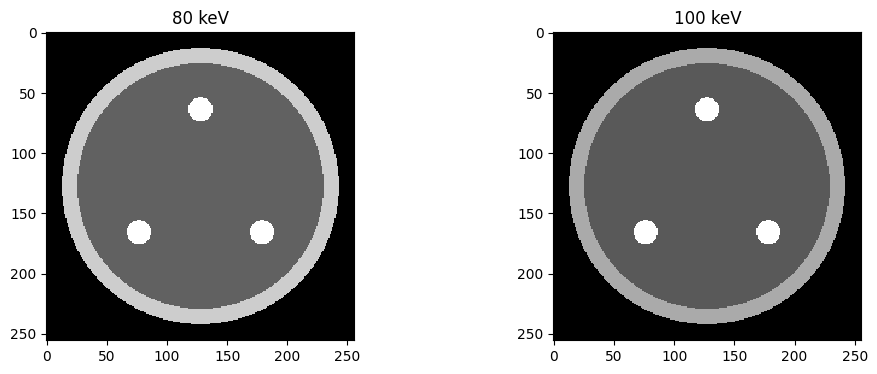

In [3]:
# in g/cm3
dilution = 0.5
densities = {'Brain':1.043,
             'Bone': 1.8,
             'Iodine': 7.874*dilution
            }
massAttenuationCoefficient = {'Brain':  {80: 1.831e-1,
                                        100: 1.701e-1},
                              'Bone':   {80: 2.229e-1,
                                        100: 1.855e-1},
                              'Iodine': {80: 5.952e-1,
                                        100: 3.717e-1}
                             }
def buildImage(kev):
    N = 256
    img = np.zeros((N,N))
    rr, cc = disk(((N-1)*0.5,(N-1)*0.5),(N-1)*0.45)
    img[rr,cc] = massAttenuationCoefficient['Bone'][kev]*densities['Bone']
    rr, cc = disk(((N-1)*0.5,(N-1)*0.5),(N-1)*0.4)
    img[rr,cc] = massAttenuationCoefficient['Brain'][kev]*densities['Brain']
    rr, cc = disk(((N-1)*0.25,(N-1)*0.5),10)
    img[rr,cc] = massAttenuationCoefficient['Iodine'][kev]*densities['Iodine']
    rr, cc = disk(((N-1)*0.65,(N-1)*0.7),10)
    img[rr,cc] = massAttenuationCoefficient['Iodine'][kev]*densities['Iodine']
    rr, cc = disk(((N-1)*0.65,(N-1)*0.3),10)
    img[rr,cc] = massAttenuationCoefficient['Iodine'][kev]*densities['Iodine']
    return img

img = {80:buildImage(80), 100:buildImage(100)}

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(img[80],vmin=0,vmax=0.5)
ax[0].set_title('80 keV')
ax[1].imshow(img[100],vmin=0,vmax=0.5)
ax[1].set_title('100 keV')
plt.show()

Nous allons générer les sinogrammes correspondant à ces deux images. Si ASTRA est une très bonne toolbox pour vous amuser à générer différentes géométries d'acquisition, utiliser des algorithmes de reconstruction itérative, etc., il existe également une fonction standard de scikit-image pour la géométrie parallèle 2D : `radon` pour la projection, et `iradon` pour la reconstruction. On écrira, pour projeter une image selon un vecteur d'angles `theta` :

`radon(img, theta=theta, circle=True, preserve_range=True)`

De même, pour reconstruire l'image à partir de son sinogramme, on écrira :

`iradon(sino, theta=theta, circle=True)`

### Questions

1. Générez les sinogrammes des deux images ci-dessus. Attention : les images sont en cm^{-1}. Vous allez projeter, donc intégrer sur une dimension de longueur : assurez-vous que cette longueur est bien en cm et pas en pixels !
2. Reconstruisez les images issues de ces sinogrammes. Attention : n'oubliez pas de diviser par le même facteur multiplicatif pour récupérer la bonne unité !

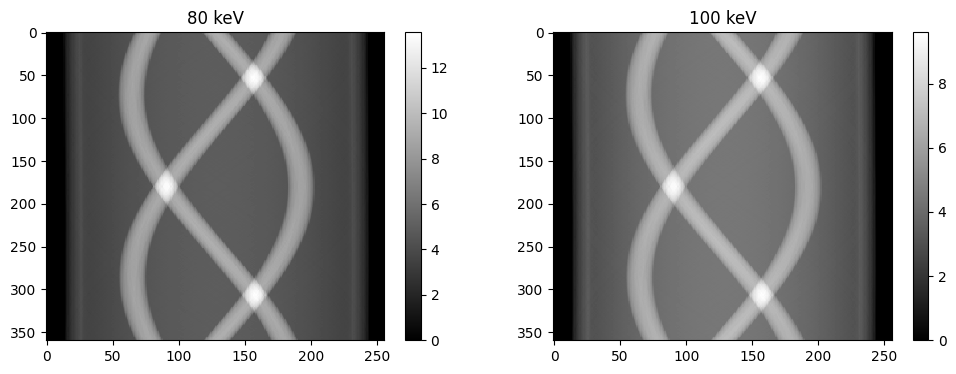

In [4]:
pixel2cm = 0.1 #transforms pixel size into cm


# Question 1
# Sauvez les sinogrammes dans un dictionnaire :
# p = {kv: [le sinogramme au bon kv] for kv in img.keys()}
def project(im,theta):
    r = radon(im, theta=theta, circle=True, preserve_range=True)
    return r * pixel2cm
p = {kv: project(img[kv],theta) for kv in img.keys()}

fig, ax = plt.subplots(1,2,figsize=(12,4))
im0 = ax[0].imshow(p[80].T)
fig.colorbar(im0,ax=ax[0])
ax[0].axis('auto')
ax[0].set_title('80 keV')
im1 = ax[1].imshow(p[100].T)
fig.colorbar(im1,ax=ax[1])
ax[1].axis('auto')
ax[1].set_title('100 keV')
plt.show()

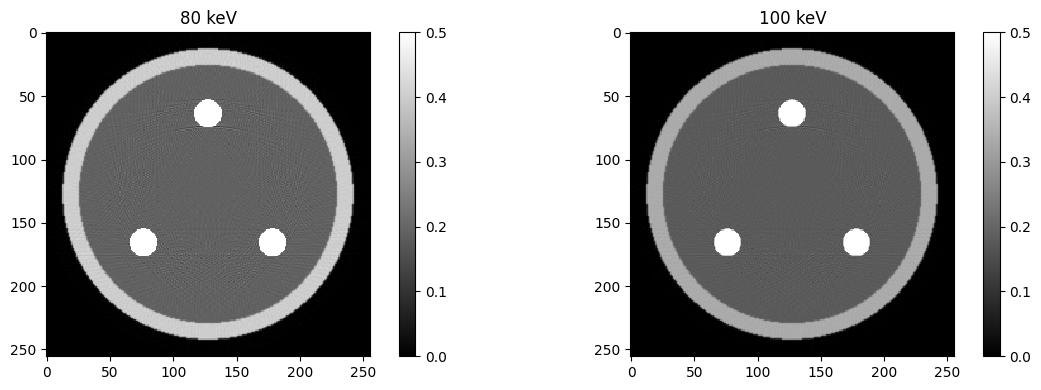

In [5]:
# Question 2
# Sauvez les reconstructions dans un dictionnaire :
# mono = {kv: [la reconstruction au bon kv] for kv in img.keys()}
def reconstruct(p,theta):
    ir = iradon(p, theta=theta, circle=True)
    return ir / pixel2cm
mono = {kv:reconstruct(p[kv],theta) for kv in img.keys()}

fig, ax = plt.subplots(1,2,figsize=(12,4))
im0 = ax[0].imshow(mono[80],vmin=0,vmax=0.5)
fig.colorbar(im0,ax=ax[0])
ax[0].set_title('80 keV')
im1 = ax[1].imshow(mono[100],vmin=0,vmax=0.5)
fig.colorbar(im1,ax=ax[1])
ax[1].set_title('100 keV')
plt.tight_layout()
plt.show()

Le modèle de Beer-Lambert polychromatique empêche la possibilité de récupérer la partie linéaire, puisque :
$$
I = \int_{\mathrm{spectre}} I_0(E)e^{-p(E)}dE.
$$
En supposant (c'est encore une nouvelle simplification, mais elle suffira à illustrer le problème) que le spectre est constitué uniquement de deux énergies $E_0$ et $E_1$, l'intensité reçue est donc $I=I_0(E_0)e^{-p(E_0)}+I_0(E_1)e^{-p(E_1)}$, qu'on peut réécrire de la façon suivante :
$$
I = I_0\left(a\times e^{-p(E_0)}+(1-a)\times e^{-p(E_1)}\right)
$$
avec $a\in[0,1]$. Si on utilise la transformation $I\mapsto \log(I_0)-\log(I)$, comme on le fait en monochromatique, on obtient ici une projection $p_E$ égale à
$$
p_E = -\log\left(a\times e^{-p(E_0)}+(1-a)\times e^{-p(E_1)}\right).
$$



On se propose de simuler une acquisition polychromatique, c'est-à-dire, une acquisition issue d'un faisceau de rayons X distribué sur plusieurs énergies. Le plus simple est de considérer une approximation bichromatique du faisceau. Dans ce contexte, on considère que les photons X incidents sont de deux énergies, à savoir 80 keV et 100 keV. La probabilité que le photon incident soit à 80 keV est donnée par $P(80) = a_{80}$, et celle d'avoir un photon incident à 100 keV est $P(100)=1-P(80)$.

### Questions
3. Avec une telle distribution de probabilité, et les sinogrammes précédemment calculés à 80 keV et 100 keV, quelle est l'intensité reçue au détecteur (on suppose $I_0=1$) ? Calculez cette intensité dans la fonction `bichromaticIntensity`.
4. Calculez la projection $p_E$ dans la fonction `bichromatic` (on suppose $I_0=1$).
5. Reconstruisez l'image à partir de ce sinogramme (n'ouvliez pas d'être dans les bonnes unités !) : qu'observez-vous ?

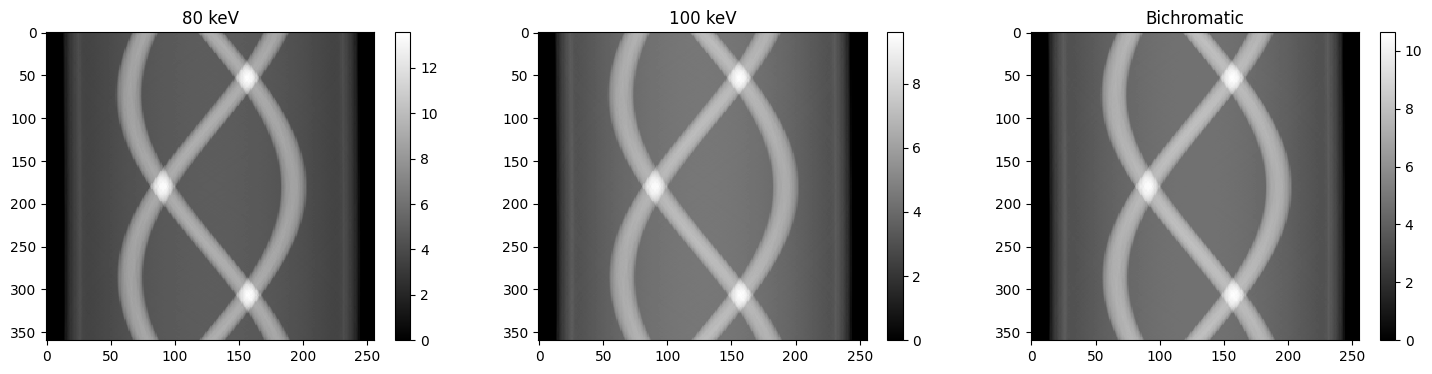

In [6]:
# Question 3
def bichromaticIntensity(p,a80=0.66):
    I0 = 1
    E0 = 80
    E1 = 100
    return I0 * (a80 * np.exp(-p[E0]) + (1 - a80) * np.exp(-p[E1]))

# Question 4
def bichromatic(p,a80=0.66):
    return -np.log(bichromaticIntensity(p, a80))

a80 = 0.66
sinogram = bichromatic(p,a80)

fig, ax = plt.subplots(1,3,figsize=(18,4))
im = ax[0].imshow(p[80].T)
ax[0].axis('auto')
ax[0].set_title('80 keV')
fig.colorbar(im,ax=ax[0])
im = ax[1].imshow(p[100].T)
ax[1].axis('auto')
fig.colorbar(im,ax=ax[1])
ax[1].set_title('100 keV')
im = ax[2].imshow(sinogram.T)
ax[2].axis('auto')
fig.colorbar(im,ax=ax[2])
ax[2].set_title('Bichromatic')
plt.show()

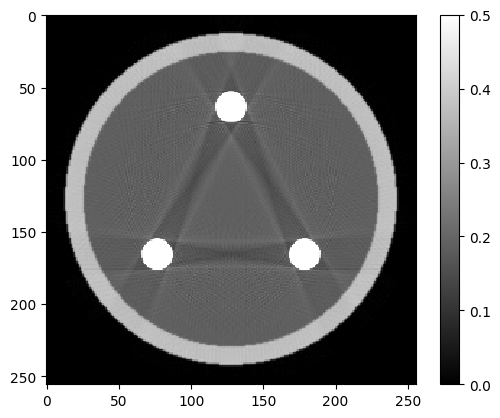

In [7]:
# Question 5
out = reconstruct(sinogram, theta)
plt.imshow(out,vmin=0,vmax=0.5)
plt.colorbar()

# Question 5 - Réponse : 
# On observe des artefacts dans la reconstruction du sinogramme bichromatique. 
# Particulièrement, on oberve des zones assombries sur les droites liant les différentes parties comprenant de l'iode.

On se propose de comprendre l'origine de ces artefacts (dits de durcissement de faisceau).

### Questions
6. Générez un vecteur d'épaisseurs en cm, variant de zéro à 5 cm (choisissez $n=500$ échantillons). Pour chaque épaisseur testée $T$, calculez $T\times \mu_{\mathrm{iodine}}(\mathrm{keV})$ pour 80 keV et 100 keV.
7. Utilisez la fonction `bichromatic` pour calculer la projection bichromatique de $T\mu_{\mathrm{iodine}}$, et tracez ce vecteur en fonction du vecteur correspondant à une acquisition monochromatique à 80 keV. Qu'observez-vous ? Pouvez-vous relier cette observation aux artefacts de l'image ci-dessus ?
8. On veut "recaler" les mesures bichromatiques à leurs mesures "idéales" monochromatiques à 80 keV. Utilisez la fonction `np.polyfit` à l'ordre 3 pour obtenir un fit polynomial des mesures bichromatiques à leurs mesures monochromatiques.

In [8]:
# Question 6
# x est un vecteur de 0 à 30 (cm) sur 500 échantillons
# iodineProjection est un dictionnaire :
# iodineProjection = {kv: [le vecteur d'épaisseur X mu(kev)] for kv in img.keys()}

x = np.linspace(0, 20, 500, endpoint=False) 
# Note étudiant : J'ai pris une valeur max de 20 (cm) pour que le résultat corresponde davantage à celui se trouvant dans "expected.pdf"

iodineProjection = {kv: x * massAttenuationCoefficient['Iodine'][kv] for kv in img.keys()} ### TBR

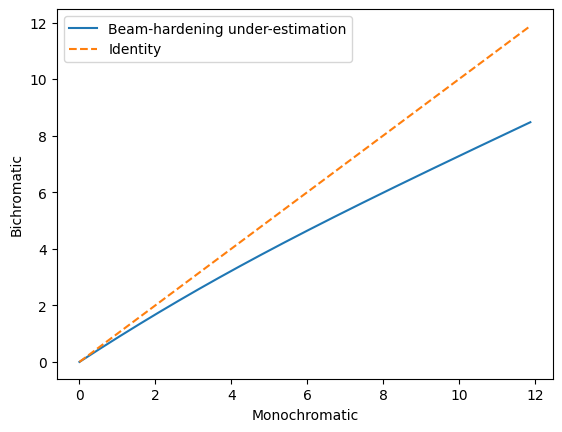

In [9]:
# Question 7
# y est la projection bichromatique de iodineProjection
# x0 est la version monochromatique de y à 80 keV
y = bichromatic(iodineProjection)
x0 = iodineProjection[80] # corresponds to monochromatic 80 keV

plt.plot(x0,y,label="Beam-hardening under-estimation")
plt.plot(x0,iodineProjection[80],'--',label='Identity')
plt.xlabel('Monochromatic')
plt.ylabel('Bichromatic')
plt.legend()
plt.show()


# Question 7 - Réponse :
# On observe que plus l'épaisseur du matériau traversé par le faisceau augmente, plus l'effet de durcissement du faisceau est sous-estimé.
# Cela coincide avec les artefacts observables dans l'image reconstruite à partir de la projection bichromatique ; 
# les artefacts étant principalement liés aux éléments de plus hautes densités, à savoir les parties comportant de l'iode.

[-0.00141778  0.04742855  1.10039443  0.01939348]


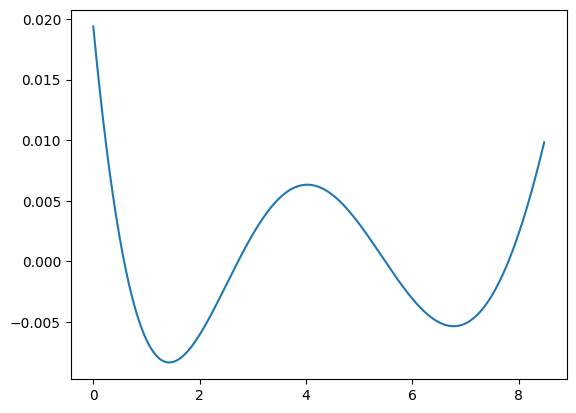

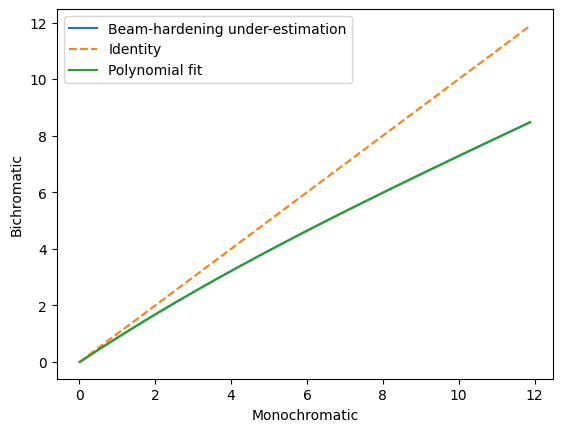

In [10]:
# Question 8

params = np.polyfit(y,x0,3)
polynomial = np.poly1d(params)
print(params)
plt.plot(y,polynomial(y)-x0)
plt.show()

plt.plot(x0,y,label="Beam-hardening under-estimation")
plt.plot(x0,iodineProjection[80],'--',label='Identity')
plt.plot(polynomial(y),y,label='Polynomial fit')
plt.xlabel('Monochromatic')
plt.ylabel('Bichromatic')
plt.legend()
plt.show()

On se propose d'utiliser ce fit polynomial pour corriger l'image. Pour cela, et en première approximation, nous allons supposer que les artefacts observés viennent uniquement des inserts d'iode. Ceux-ci sont reconstruits correctement, avec peut-être une valeur à l'intérieur de l'insert légèrement différente de la vraie valeur, mais en tout cas, ces inserts sont identifiables. Ils sont aussi beaucoup plus intenses que les autres structures de l'image reconstruite.

### Questions
9. Trouvez manuellement un seuil qui vous permette d'isoler les inserts d'iode dans l'image reconstruite : mettez tous les pixels de valeur inférieure à ce seuil à zéro dans `seg`.
10. Projetez les valeurs de ces inserts d'iode dans `segProj` ; transformez le sinogramme obtenu en utilisant le polynôme trouvé précédemment, dans la variable `transformedSegProj`.
11. Reconstruisez une image à partir de ce sinogramme transformé. On appellera `artifact` cette image.

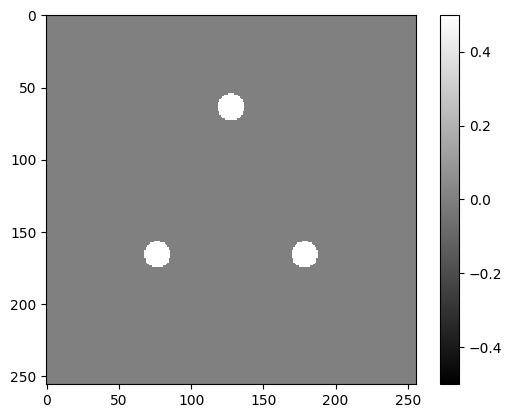

In [11]:
# Question 9
# Trouver une valeur de T (la plus petite possible, à 1e-1 près) telle que seg[out<T] = 0 ne garde que les inserts d'iode
T = 1.7
seg = out.copy()
seg[out < T] = 0
plt.imshow(seg,vmin=-0.5,vmax=0.5)
plt.colorbar()

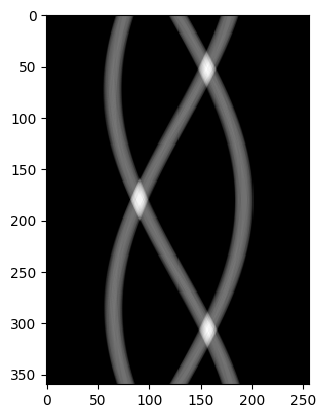

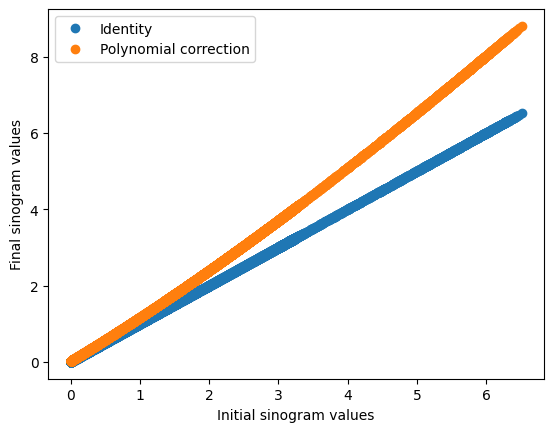

In [12]:
# Question 10
segProj = project(seg, theta)
transformedSegProj = polynomial(segProj)

plt.imshow(transformedSegProj.T)
plt.show()


plt.plot(segProj.flatten(), segProj.flatten(),'o',label='Identity')
plt.plot(segProj.flatten(), transformedSegProj.flatten(),'o',label='Polynomial correction')
plt.xlabel('Initial sinogram values')
plt.ylabel('Final sinogram values')
plt.legend()
plt.show()

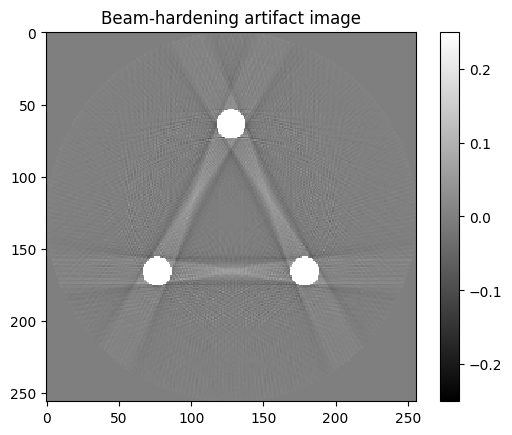

In [13]:
# Question 11
artifact = reconstruct(transformedSegProj, theta)

plt.imshow(artifact,vmin=-0.25,vmax=0.25)
plt.colorbar()
plt.title('Beam-hardening artifact image')
plt.show()

12. Lancez la cellule ci-dessous : celle-ci permet d'obtenir la région `isBrain` dans laquelle nous étudions les tissus mous

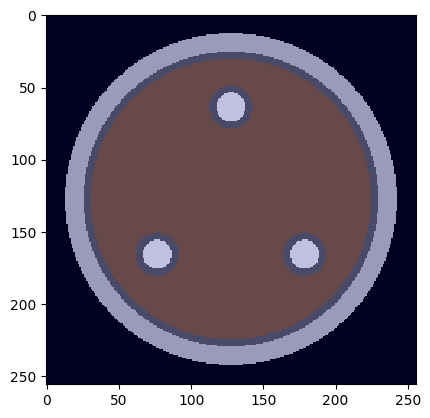

In [14]:
from skimage.morphology import binary_erosion
from skimage.morphology import disk as d
from scipy.ndimage import gaussian_filter as gf

isBrain = np.where(img[80]==massAttenuationCoefficient['Brain'][80]*densities['Brain'])
mask = np.zeros_like(img[80])
mask[isBrain] = 1
mask = binary_erosion(mask,d(5))
isBrain = np.where(mask==1)
plt.imshow(img[80],vmin=0,vmax=0.5)
plt.imshow(mask,cmap='jet',interpolation='none',alpha=0.25)

13. Ecrivez une fonction `totalVariation(u)` qui prend la variation totale de `u`: c'est la quantité suivante
$$
TV(u) = \frac{1}{N}\sum_{i=1}^N ||\nabla G_\sigma(u)_i||_2,
$$
où $N$ est le nombre de pixels de $u$, et $G_\sigma$ est un lissage gaussien de $u$. Pour cela :
- Filtrez d'abord `u` par le filtre gaussien `gf` avec $\sigma=1$
- Prenez le gradient de cette image : cela vous donne deux sorties (un gradient selon $x$, un gradient selon $y$)
- Prenez l'image $||\nabla G_\sigma(u)||_2 = \sqrt{\nabla_x G_\sigma(u)^2+\nabla_y G_\sigma(u)^2}$
- Dans la région définie par `isBrain` : prenez la moyenne de cette image

In [15]:
# Question 13
def totalVariation(u):
    gf_u = gf(u, 1)
    gx,gy = np.gradient(gf_u)
    img = np.sqrt(gx ** 2, gy ** 2)
    return np.sum(img[isBrain]) / img[isBrain].shape[0]

On se propose de corriger l'image reconstruite en lui ajoutant $\alpha\times$ `artifact` ; pour savoir quelle valeur de $\alpha$ choisir, on se propose de parcourir un intervalle de valeurs donné par `search`. La valeur de cet intervalle qui donnera la plus petite variation totale dans les tissus mous sera la valeur choisie.

14. Dans le code ci-dessous, enregistrez la variation totale de la correction candidate dans un conteneur ; déduisez-en la valeur optimale de `alpha`.

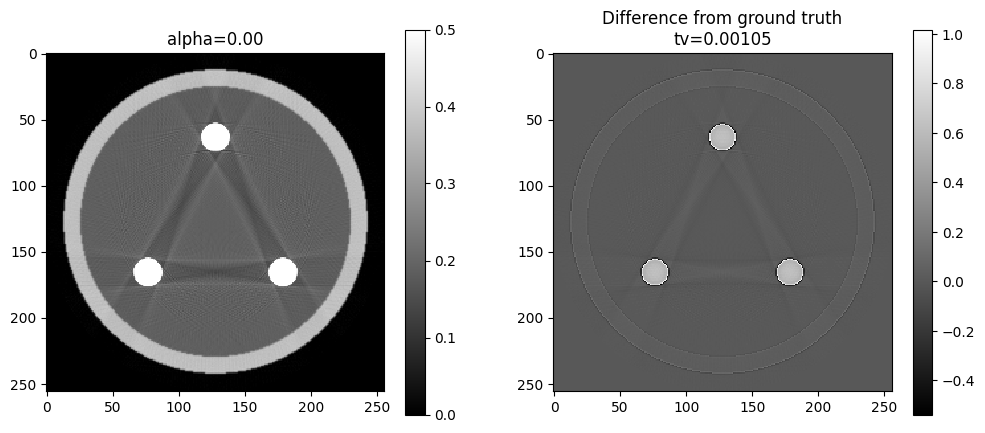

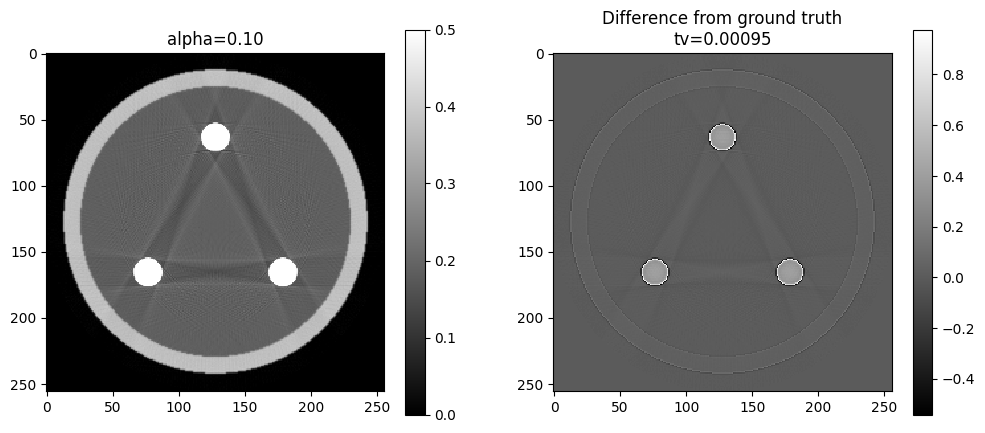

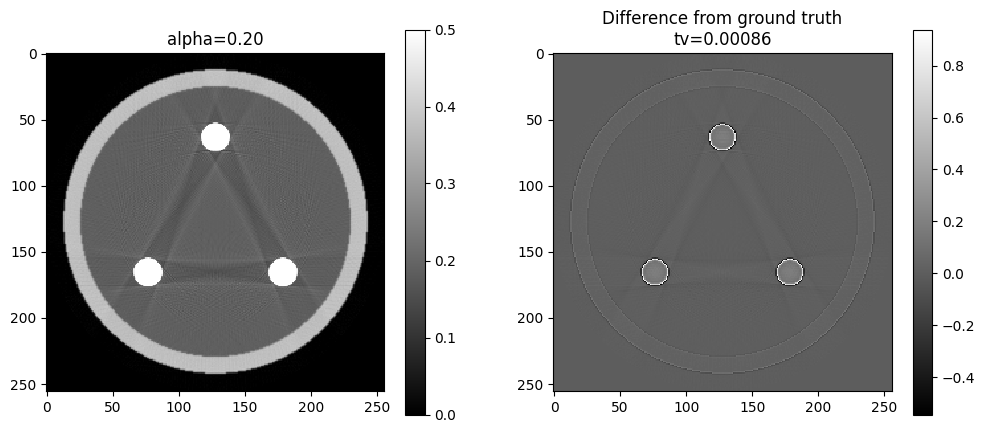

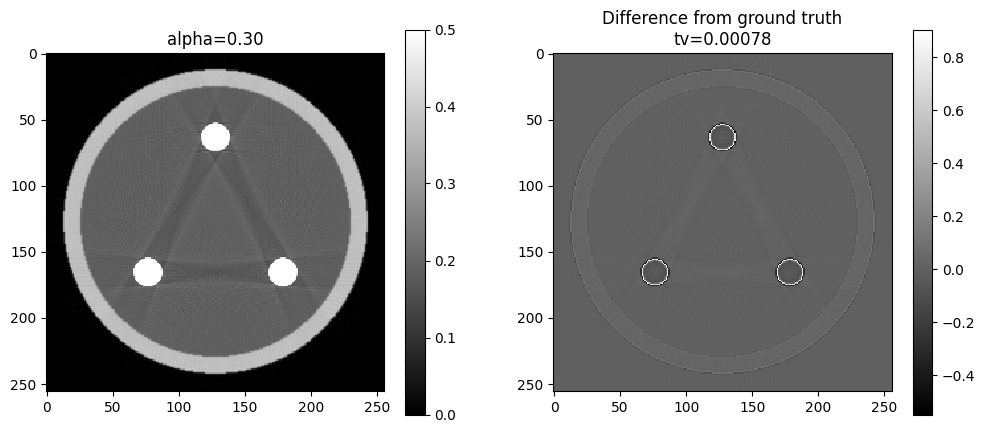

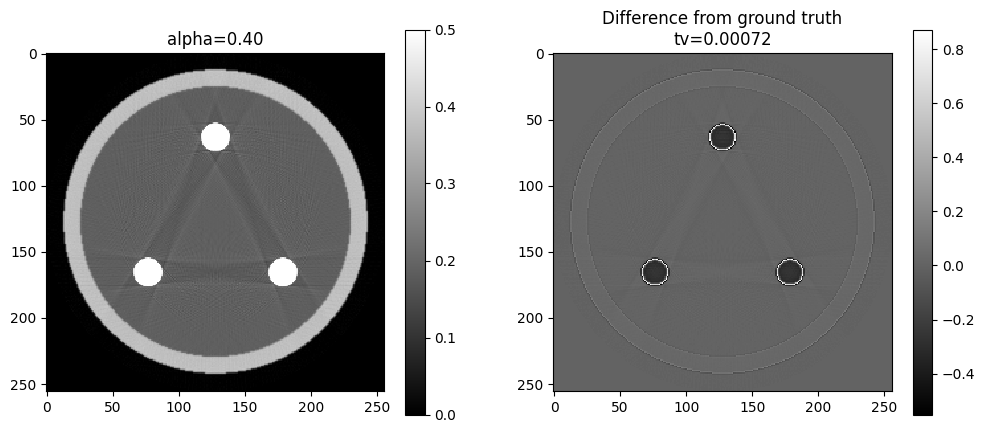

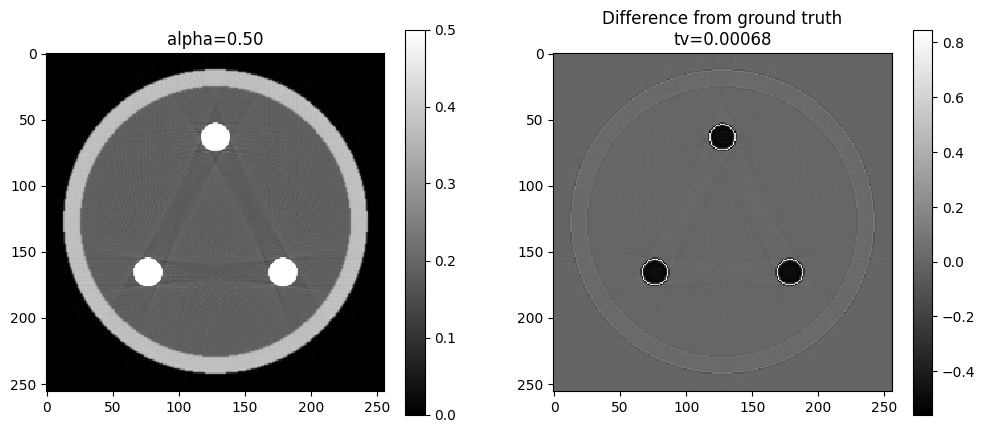

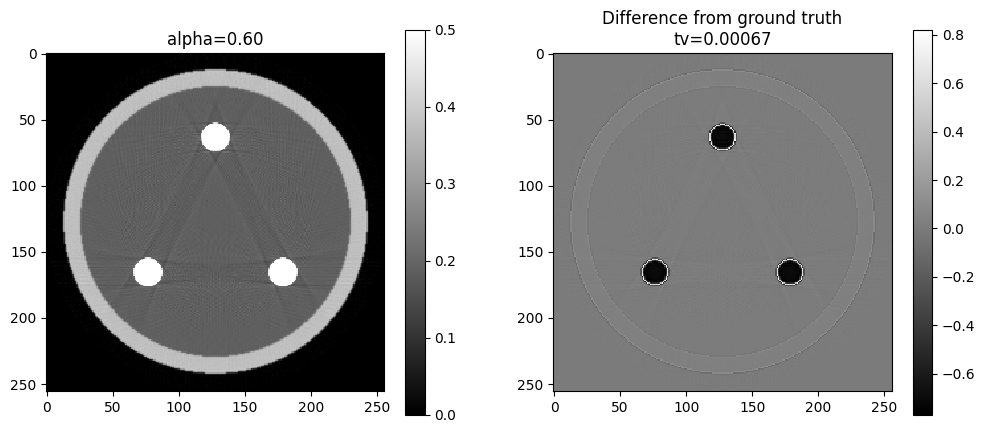

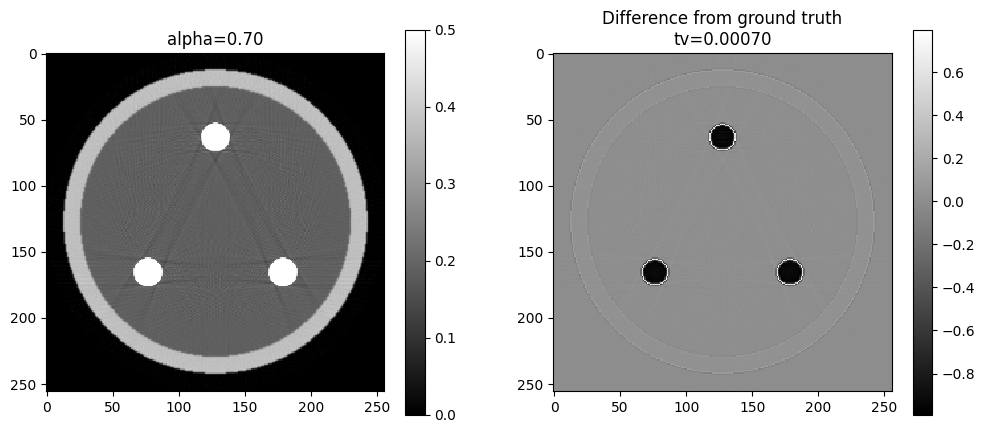

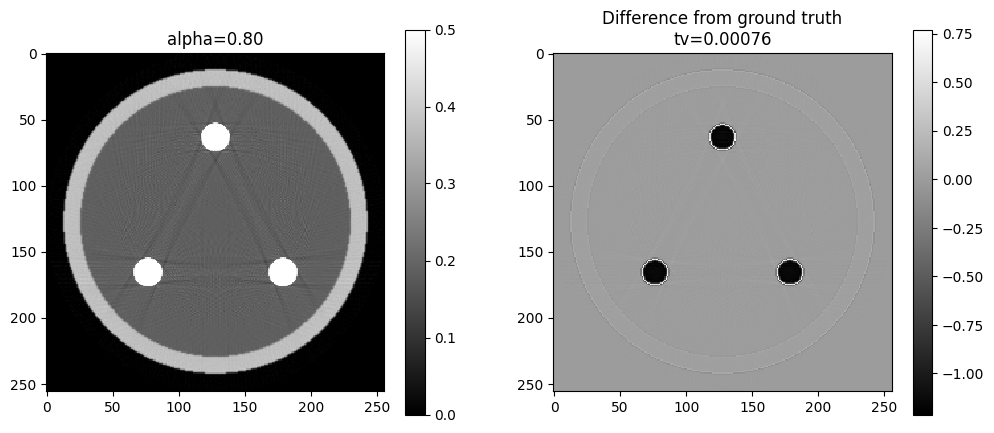

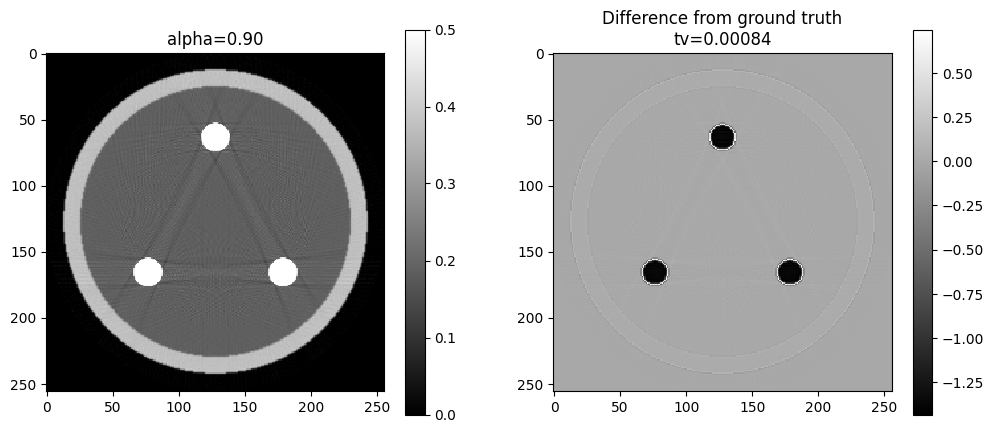

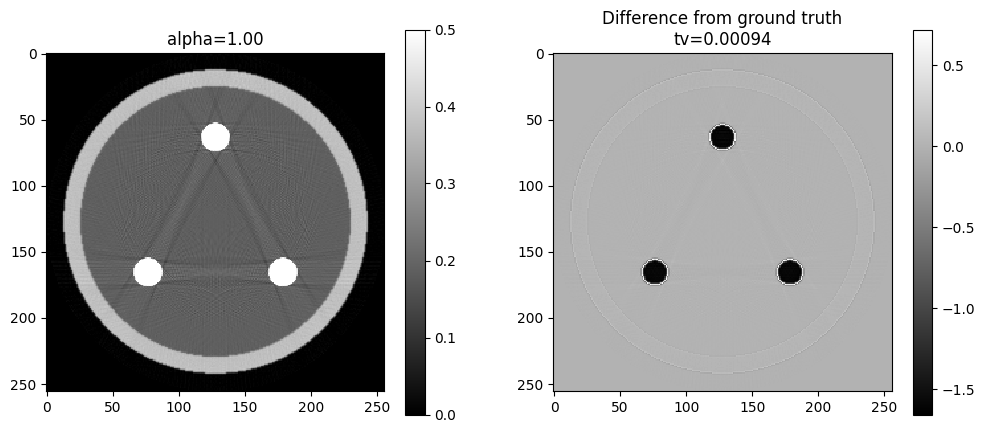

In [16]:
# Question 14
search = np.linspace(0,1,11)
scores = []
for alpha in search:
    rec = out+alpha*artifact
    tv = totalVariation(rec) # changed
    scores.append(tv) # changed
    f,ax = plt.subplots(1,2,figsize=(12,5))
    im = ax[0].imshow(rec,vmin=0,vmax=0.5)
    ax[0].set_title(f'{alpha=:.2f}')
    f.colorbar(im,ax=ax[0])
    im = ax[1].imshow(img[80]-rec)
    f.colorbar(im,ax=ax[1])
    ax[1].set_title(f'Difference from ground truth\n{tv=:.5f}')
    plt.show()

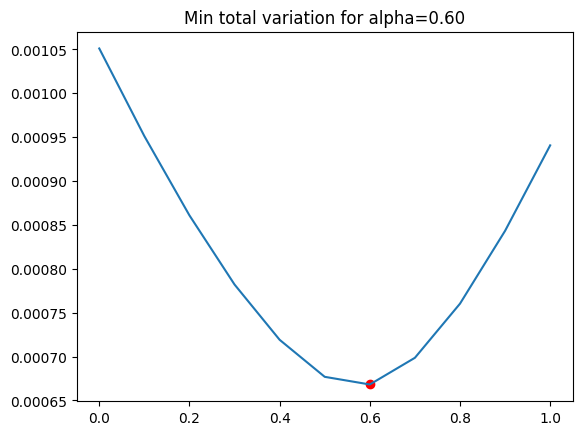

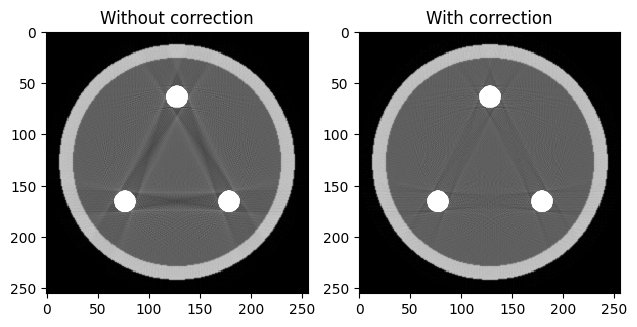

In [17]:
# Question 14 (suite)
# idx est l'indice qui fournit la variation totale la plus faible
# alpha est la valeur associée à cet indice
idx = np.argmin(scores)
alpha = search[idx]

errors = scores
tmp = artifact

plt.plot(search,errors)
plt.scatter(alpha,errors[idx],color='r')
plt.title(f'Min total variation for {alpha=:.2f}')
plt.show()
fig,ax = plt.subplots(1,2)
ax[0].imshow(out,vmin=0,vmax=0.5)
ax[0].set_title('Without correction')
ax[1].imshow(out+alpha*tmp,vmin=0,vmax=0.5)
ax[1].set_title('With correction')
plt.tight_layout()
plt.show()

On pourra alors conserver cette valeur optimale comme valeur de correction du durcissement de faisceau de l'iode, pour une concentration donnée ; si vous changez la concentration, le facteur changera ! Vous pouvez faire le même exercice pour d'autres matériaux bien communs, comme l'os du crâne, l'eau, etc.

# Partie 2 - Non-idéalités du détecteur

Un détecteur présente plusieurs non idéalités ; en premier lieu, il présente des dérives en gains et en offsets. Cela signifie que la mesure faite au niveau d'une cellule du détecteur (un pixel d'un détecteur plan, ou un bin d'un détecteur linéaire), au lieu de mesurer l'intensité $I$ des photons X qui arrivent à la cellule, on mesure
$$
I_c = \alpha I + \beta.
$$
$\alpha$ est un gain (proche de 1 généralement), et $\beta$ est un offset. Si on ne fait pas attention à $\alpha$ et $\beta$, on se retrouve avec une projection corrompue $p_c = \log(I_0)-\log(I_c)$.

Chargez l'image ci-dessous, et regardez son sinogramme :

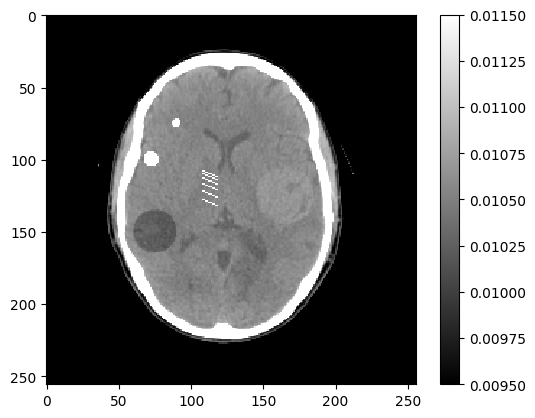

In [18]:
scale = 1e-5
img = np.fromfile('CTscan.raw',dtype='float32').reshape((256,256))*scale
ctDisplay = {'vmin':950*scale,'vmax':1150*scale}
plt.imshow(img,**ctDisplay)
plt.colorbar()

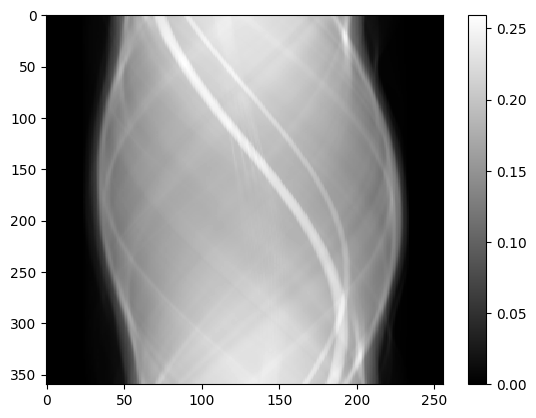

In [19]:
sinogram = project(img, theta=theta)
# keep a copy
sinogram0 = sinogram.copy()
plt.imshow(sinogram.T, aspect='auto')
plt.colorbar()

Reconstruisez l'image à partir de ce sinogramme :

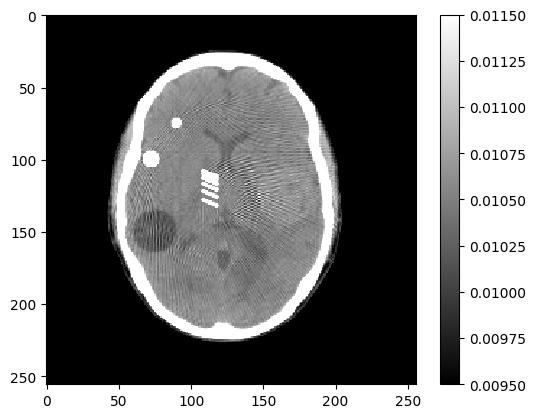

In [20]:
img = reconstruct(sinogram, theta=theta)
plt.figure()
plt.imshow(img,**ctDisplay)
plt.colorbar()

### Questions
1. Partant du détecteur utilisé pour le sinogramme précédent (de taille `sinogram.shape[0]`), générer un vecteur de gains égaux à 1 et un vecteur d'offsets égaux à 0 (cas idéal). Corrompez le vecteur de gain tous les 8 bins par un bruit d'écart-type de 1%. Affichez le vecteur des gains. Générez le sinogramme qui aurait été obtenu si la mesure avait subi ces gains à chaque acquisition. Reconstruisez l'image : qu'observez-vous comme artefacts ?
2. Corrompez le vecteur d'offsets tous les 8 bins (en partant de l'indice 4 cette fois) par un bruit d'écart-type de 1%. Affichez le vecteur des offsets.
3. Partez de `sinogram0`, et générez le sinogramme qui aurait été obtenu si la mesure avait subi ces gains et ces offsets à chaque acquisition (fixez `I0=1`).
4. Reconstruisez l'image : qu'observez-vous comme artefacts ? Changez la valeur de `I0` à 10, 100, 10000 : qu'observez-vous ? Quels artefacts disparaissent / se maintiennent ? Pourquoi ?

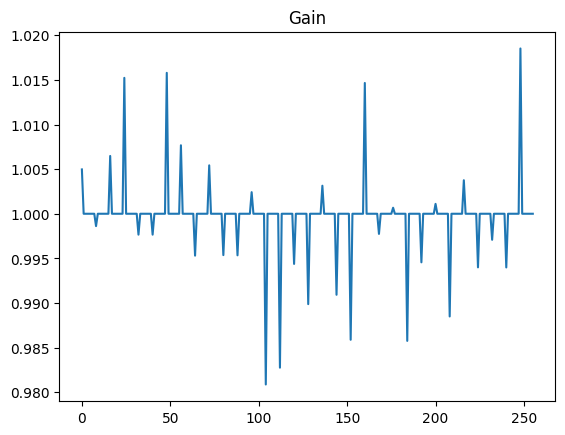

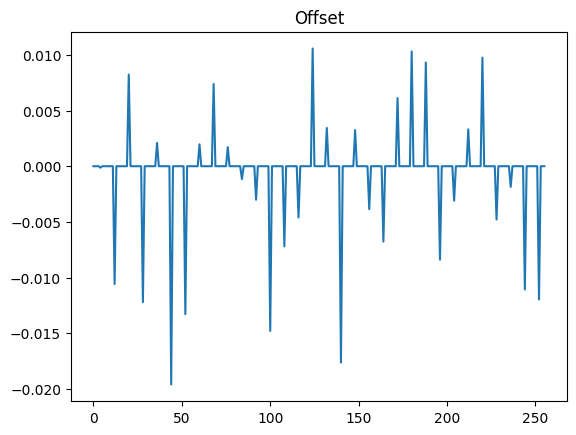

In [21]:
np.random.seed(42)

# Question 1
gain = np.ones(sinogram.shape[0])
gain[::8] += np.random.normal(loc=0, scale=0.01, size=gain[::8].shape)
plt.figure()
plt.plot(gain)
plt.title('Gain')
plt.show()

# Question 2
offset = np.zeros(sinogram.shape[0])
offset[4::8] += np.random.normal(loc=0, scale=0.01, size=offset[4::8].shape)
plt.figure()
plt.plot(offset)
plt.title('Offset')
plt.show()

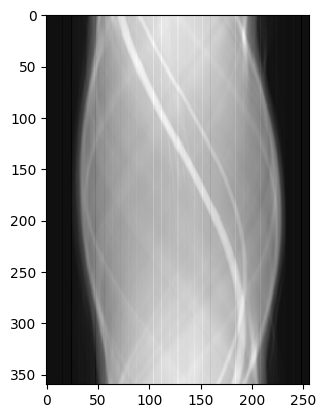

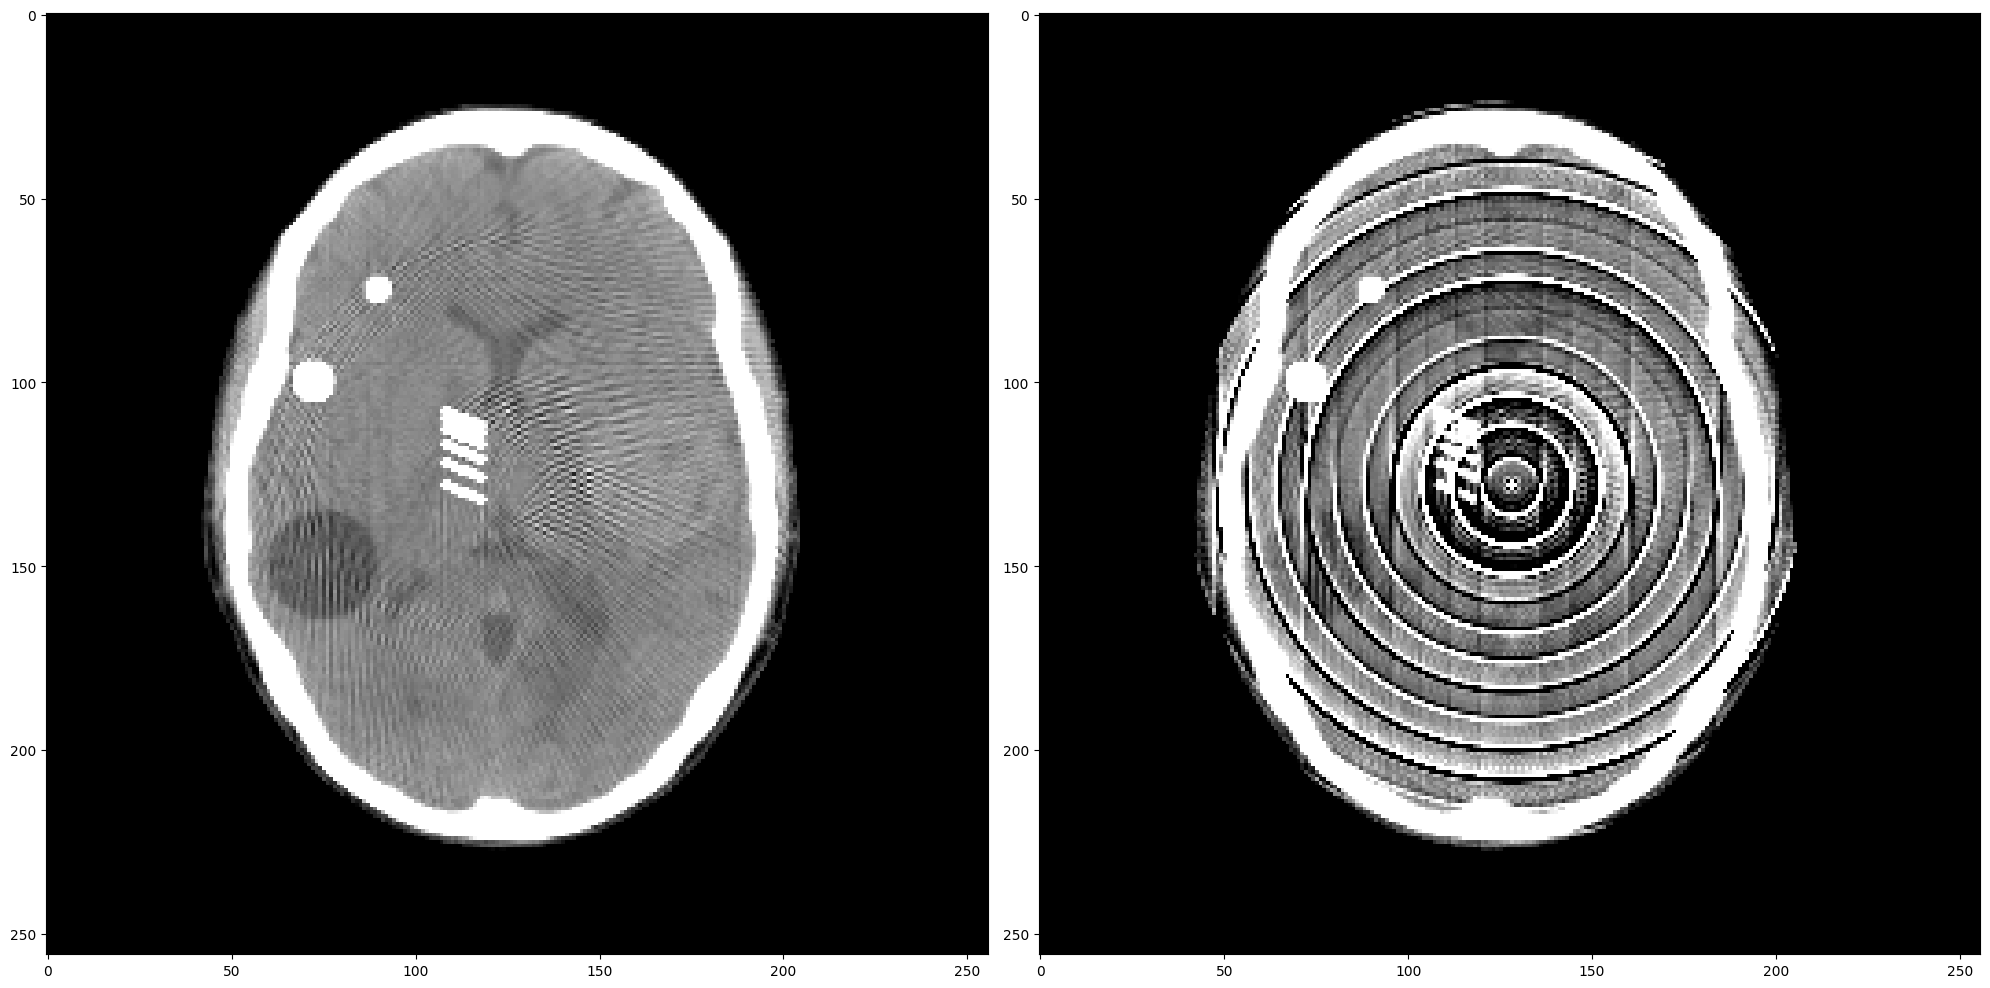

In [22]:
# Question 3

I0 = 100
# Note étudiant : J'ai gardé la valeur de I0 à 100 pour obtenir une image au plus proche de celle du fichier "expected.pdf".

I = np.exp(np.log(I0) - sinogram0)
sinogram = np.log(I0) - np.log(gain[:, np.newaxis] * I + offset[:, np.newaxis])
plt.figure()
plt.imshow(sinogram.T)
plt.show()

# Question 4

out = reconstruct(sinogram, theta=theta)
f,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(img,**ctDisplay)
ax[1].imshow(out,**ctDisplay)
plt.tight_layout()

# Question 4 - Réponse :
#
# On observe comme artefacts une multitude de cercles ou de spirales entourant notre image reconstruite lorsque la mesure subit un gain et un offset.
# Lorsque l'on augmente la valeur de I0 (à 10, 100, puis 10000), on observe que les spirales s'affaissent 
# ou diminuent en nombre pour laisser place aux détails de l'image d'origine.
# En revanche, en augmentant la valeur de I0, on observe que le centre de l'image reconstruite est plus sombre que celle d'origine.
#
# L'ajout d'un gain et d'un offset peuvent amener certaines valeurs à dépasser la plage dynamique de l'image, 
# entrainant des artefacts comme des annaux.
# Cependant, l'augmentation de I0 peut fournir des données plus précises et réduire les erreurs statistiques, 
# ce qui peut aider à atténuer les artefacts.

On se donne une collection d'images de noir et d'images de blanc : les images de noir sont des lectures à vide (sans exposition aux rayons X), les images de blanc sont des expositions uniformes.

4. A partir de ces collections, estimez les vecteurs `offsetEstimate` et `gainEstimate`, qui seront vos estimées des vecteurs idéaux `gain` et `offset` (qui sont a priori inaccessibles).

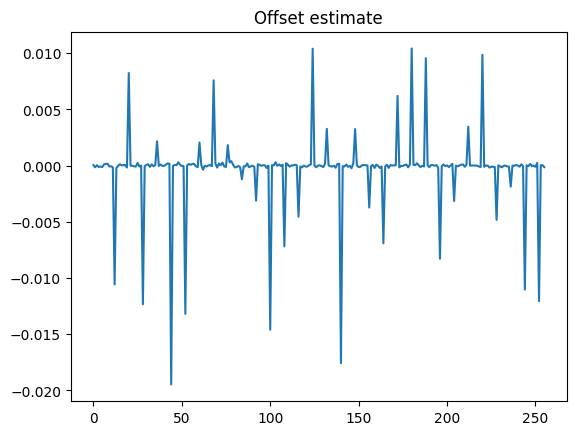

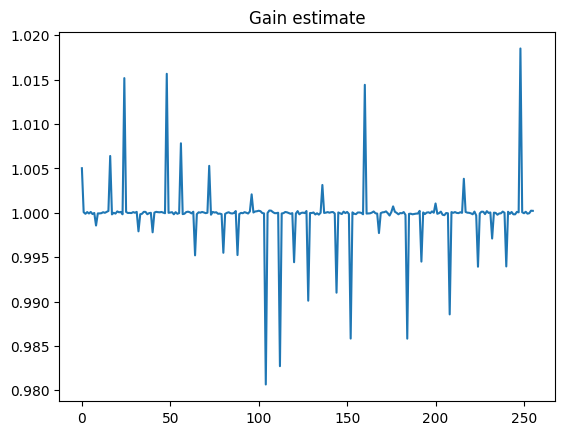

In [23]:
blackAcquisitions = np.array([offset+5e-4*np.random.randn(offset.size) for n in range(20)])
whiteAcquisitions = np.array([gain+5e-4*np.random.randn(gain.size) for n in range(20)])

# Question 4
offsetEstimate = np.mean(blackAcquisitions, axis=0)
plt.plot(offsetEstimate)
plt.title('Offset estimate')
plt.show()
gainEstimate = np.mean(whiteAcquisitions, axis=0)
plt.plot(gainEstimate)
plt.title('Gain estimate')
plt.show()

5. Corrigez `sinogram` en gain et en offset : n'oubliez pas que la correction s'effectue non pas sur $p$, mais sur $I_0e^{-p}$ !
6. Reconstruisez le sinogramme corrigé : qu'observez-vous ?

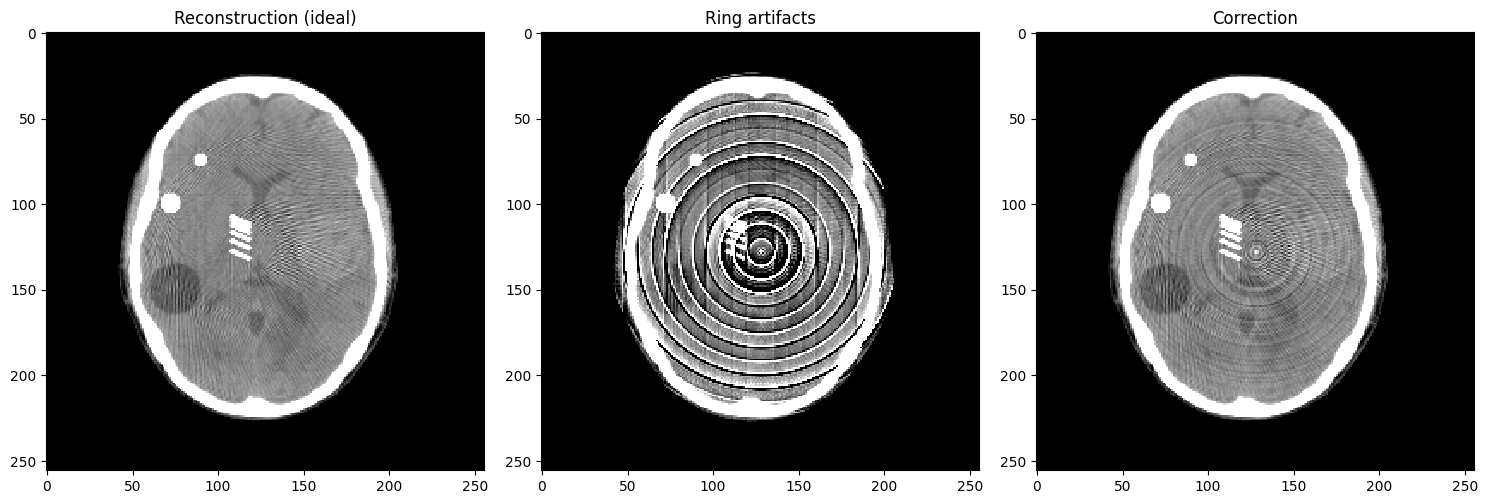

In [24]:
# Question 5
I = np.exp(np.log(I0) - sinogram)
correctedSinogram = np.log(I0) - np.log((I - offsetEstimate[:, np.newaxis]) / gainEstimate[:, np.newaxis])
# Question 6
corrected = reconstruct(correctedSinogram, theta=theta)

f,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img,**ctDisplay)
ax[0].set_title('Reconstruction (ideal)')
ax[1].imshow(out,**ctDisplay)
ax[1].set_title('Ring artifacts')
ax[2].imshow(corrected,**ctDisplay)
ax[2].set_title('Correction')
plt.tight_layout()

# Question 5 - Réponse :
# On observe que les artefacts ont été fortement atténués voire supprimés. 
# Il reste cependant quelques spirales atténués visibles sur l'image corrigée.